In [3]:
import pandas as pd
import numpy as np
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm_notebook
import pywt
url='https://raw.githubusercontent.com/huddyyeo/RL_for_trading/master/HSBA.L.csv'
start_date='2000-01-01'

# silence warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

!pip install ta
import ta


  Created wheel for ta: filename=ta-0.5.11-cp36-none-any.whl size=23031 sha256=d35c70c9e9c2b491895442432eeff6e41bec1e08b3b79663de794bc0d8bc2a85
  Stored in directory: /root/.cache/pip/wheels/97/32/1d/cbc724a8ecaec6e426baf57ab8c4c2cdc687aadd7427280b1f
Successfully built ta


In [79]:
from google.colab import drive
drive.mount('/content/drive/')
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using gpu') #using GPU
else:
    device = torch.device('cpu')
    print('using cpu') #using CPU

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
using gpu


In [0]:
def wavelet(data,wave_type='sym4',threshold=0.04):
  w = pywt.Wavelet('sym4')
  maxlev = pywt.dwt_max_level(len(data), w.dec_len)
  coeffs = pywt.wavedec(data, wave_type, level=maxlev)
  for i in range(1,len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
  return pywt.waverec(coeffs, wave_type)


In [0]:
#scaler class, reduces values to 0-1

class MinMaxScaler():
  
  def __init__(self,scale=[0,1]):
    self.min=scale[0]
    self.scale=1/(scale[1]-scale[0])
    
  def fit_transform(self, array):
    length=array.shape[1]
    final_array = np.zeros(array.shape)
    self.scale=np.zeros(length)
    self.min=np.zeros(length)
    
    for i in range(length):
      scale=np.max(array[:,i])-np.min(array[:,i])
      if (scale==0):
        scale=1
      scale=1/scale
      self.scale[i]=scale
      self.min[i]=np.min(array[:,i])
      final_array[:,i]=(array[:,i]-np.min(array[:,i]))*scale
    return final_array
  
  def inverse_transform(self,array):
    final_array = np.zeros(array.shape)
    for i in range(array.shape[1]):
      final_array[:,i]=(array[:,i]/self.scale[i])+self.min[i]
    return final_array
  
  def transform(self,array):
    final_array=np.zeros(array.shape)
    for i in range(array.shape[1]):
      final_array[:,i]=(array[:,i]-self.min[i])*self.scale[i]
    return final_array

In [0]:
class Environment(object):
  def __init__(self,url,start_date,val_count=0.8,test_count=0.90):
    
    self.training_window=253
    self.url=url
    self.start_date=start_date
    self.scaler=MinMaxScaler()

    self.market_data=self.init_data(url,start_date)
    self.log_returns,self.returns=self.init_labels()    
    
    self.num_days=len(self.market_data)   
    self.val_count=int(self.num_days*val_count)
    self.test_count=int(self.num_days*test_count)
    
    self.scaled_market_data=self.scale_data()

  def scale_data(self):           
    all_data=self.market_data.copy().values
    all_data[:self.val_count]=self.scaler.fit_transform(all_data[:self.val_count])
    all_data[self.val_count:]=self.scaler.transform(all_data[self.val_count:])
    return all_data
    
  def init_data(self,url,start_date):
    #retrieving data
    data=pd.read_csv(url)
    data.at[8002,'Low']=data.loc[8001,'Low'] #correcting a specific error in the raw data
    data=data[data['Date']>=start_date]
    data=data.reset_index().drop(columns=['Adj Close','index'])
    data=self.pre_process(data)
    #data=self.denoise(data)
    return data
  
  def denoise(self,data):
    data.at[:,'High']=pd.Series(wavelet(data.loc[:,"High"].values,wave_type='sym4',threshold=0.05))
    data.at[:,'Low']=pd.Series(wavelet(data.loc[:,"Low"].values,wave_type='sym4',threshold=0.05))
    return data

  def init_labels(self):
    #calculate returns
    current_day_high=self.market_data.loc[:,'High']
    current_day_low=self.market_data.loc[:,'Low']
    next_day_high=current_day_high.shift(-1)
    next_day_low=current_day_low.shift(-1)
    returns_high=next_day_high/current_day_high
    returns_low=next_day_low/current_day_low
    log_returns_high=np.log(returns_high).values
    log_returns_high=np.expand_dims(log_returns_high,axis=1)
    log_returns_low=np.log(returns_low).values
    log_returns_low=np.expand_dims(log_returns_low,axis=1)

    returns=pd.concat([returns_high,returns_low],axis=1)
    log_returns=np.concatenate([log_returns_high,log_returns_low],axis=1)
    return log_returns,returns
  
  def get_indicators(self,data):
    #calculate all indicators
    open=data.loc[:,'Open']
    high=data.loc[:,'High']
    low=data.loc[:,'Low']
    close=data.loc[:,'Close']
    volume=data.loc[:,'Volume']
    
    data['rsi']=ta.momentum.rsi(close)
    data['uo']=ta.momentum.uo(high,low,close)
    data['kama']=ta.momentum.ao(high, low)
    
    data['eom']=ta.volume.ease_of_movement(high, low, close, volume)
    data['cmd']=ta.volume.chaikin_money_flow(high, low, close, volume)
    data['nvi']=ta.volume.negative_volume_index(close, volume)
    
    data['boll_high']=ta.volatility.bollinger_hband_indicator(close)
    data['atr']=ta.volatility.average_true_range(high, low, close)
     
    data['aroon']=ta.trend.aroon_down(close)
    data['dpo']=ta.trend.dpo(close)
    data['macd_diff']=ta.trend.macd_diff(close)
    data['vortex']=ta.trend.vortex_indicator_neg(high, low, close)
    
    return data
  
  def pre_process(self,data):
    data['Date']=pd.to_datetime(data['Date'])
    data=data.resample('D',on='Date').first().fillna(method='ffill')
    data=self.get_indicators(data)
    data=data.dropna()
    data=data.drop(columns=['Date'])

    return data
    

In [0]:
environment=Environment(url,start_date)

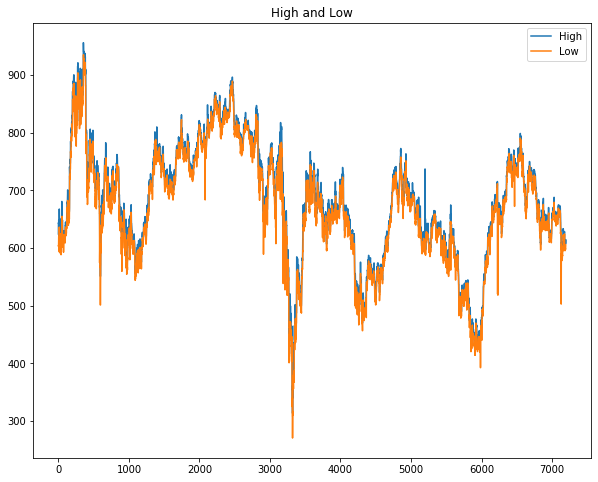

In [39]:
plt.figure(figsize=[10,8])
plt.title('High and Low')
plt.plot(environment.market_data.loc[:,"High"].values,label='High')
plt.plot(environment.market_data.loc[:,"Low"].values,label='Low')
plt.legend()
plt.show()

The training data looks somewhat stationary with no major, consistent trends. Thus appears to be a good training dataset.

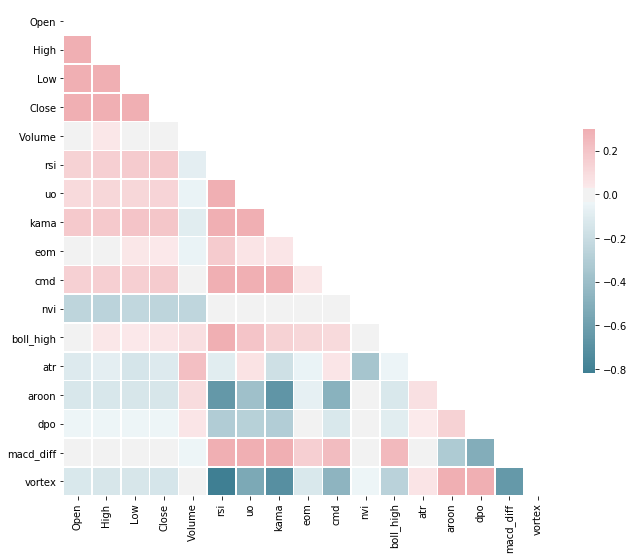

In [40]:
#correlation matrix of indicators, n
corr=environment.market_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [0]:
class DeepNetwork(nn.Module):
  def __init__(self,dim_0,dim_1=256,dim_2=256,dim_a=256,dropout=0.2,gru_layers=1):
    super(DeepNetwork,self).__init__()
    self.dim_0=dim_0
    self.dim_1=dim_1
    self.dim_2=dim_2    
    self.dim_a=dim_a

    self.linear=nn.Linear(dim_0,dim_1) 
    self.gru=nn.GRU(dim_1,dim_2,batch_first=True,num_layers=gru_layers)
    self.linear_a1=nn.Linear(dim_2,dim_a)
    self.linear_a2=nn.Linear(dim_a,dim_2)
    self.linear_out=nn.Linear(dim_2,2)

    self.dropout=nn.Dropout(dropout)
    
    self.relu=nn.ReLU()
    self.tanh=nn.Tanh() 
    self.sigmoid=nn.Sigmoid()
    self.softmax=nn.Softmax()
    
  def forward(self,x):
    
    #linear layer and relu
    out=self.linear(x) 
    out=self.dropout(out)
    out=self.relu(out) 

    #GRU
    out,_=self.gru(out,)

    #soft attention
    a=self.linear_a1(out)
    a=self.dropout(a)
    a=self.relu(a)
    a=self.linear_a2(out)
    a=self.dropout(a)
    a=self.tanh(a)
    a=self.softmax(a)
    a=a*out

    #linear layer and relu     
    out=self.linear_out(a)
    
    return out
  

class TrainingEnv():
  def __init__(self,environment,dim_1=256,dim_2=256,dim_a=256,lr=1e-4):
    dim_0=environment.scaled_market_data.shape[-1]
    self.model=DeepNetwork(dim_0=dim_0,dim_1=dim_1,dim_2=dim_2,gru_layers=1)
    self.model.to(device)
    self.training_hidden=None
    self.test_hidden=None
    self.count=0
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr,amsgrad=True)
    self.environment=environment
    self.criterion = nn.MSELoss()
    self.training_loss=[]
    self.lr=lr
    
  def reset_hidden(self):
    self.training_hidden=None
    self.test_hidden=None
    
  def train_once(self,training_data,label_data):
    #training one sample
    train=Variable(torch.from_numpy(training_data)).float().to(device)
    label=Variable(torch.from_numpy(label_data)).float().to(device)
    self.model.train()
    self.optimizer.zero_grad()
    

    out=self.model(train)
    out=out[:,-1,:]
    loss=self.criterion(out,label)
    loss.backward()
    self.optimizer.step()
    return loss.item()

  def train_one_epoch(self):
    loss=np.array([])
    #randomize the training windows
    window=self.environment.training_window
    train_space=np.arange(self.environment.val_count-window)
    total=len(train_space)
    np.random.shuffle(train_space)
    train_space=np.nditer(train_space)
    print('training...')
    for date in tqdm_notebook(train_space,total=total):
      train=self.environment.scaled_market_data[date:date+window]
      train=np.expand_dims(train,axis=0)
      label=self.environment.log_returns[date+window-1]
      loss=np.append(loss,self.train_once(train,label))
    print('completed training')
    self.evaluate_model()
    return(np.mean(loss))

  def get_val_loss(self):
    start=self.environment.val_count
    end=self.environment.test_count
    val_data=self.environment.scaled_market_data[start-self.environment.training_window:end]
    label=self.environment.log_returns[start:end]
    val_loss=self.model_eval(val_data)
    val_loss=val_loss[self.environment.training_window:]
    hmse=val_loss[:,0]-label[:,0]
    hmse=np.mean(np.square(hmse))
    lmse=val_loss[:,1]-label[:,1]
    lmse=np.mean(np.square(lmse))
    return(hmse,lmse)

  def model_eval(self,eval_data):
    #feed given eval data through network
    eval_data=np.expand_dims(eval_data,axis=0)
    eval=Variable(torch.from_numpy(eval_data)).float().to(device)
    self.model.eval()
    with torch.no_grad():
      out=self.model(eval)
    return np.squeeze(out.cpu().detach().numpy())

  def evaluate_model(self):    
    #evaluation of test set
    index=len(self.environment.market_data)-self.environment.test_count
    start=self.environment.test_count-self.environment.training_window
    out=self.model_eval(self.environment.scaled_market_data[start:])
    out=out[self.environment.training_window:]
    high=np.exp(out[:,0])*self.environment.market_data.loc[:,'High'].values[-1*index:]
    high=high[:-1]
    low=np.exp(out[:,1])*self.environment.market_data.loc[:,'Low'].values[-1*index:]
    low=low[:-1]

    plt.figure(figsize=[10,8])

    plt.subplot(2,1,1)
    plt.plot(high,label='pred high')
    plt.plot(self.environment.market_data.loc[:,'High'].values[-1*index+1:],label='actual')
    plt.legend()
    mse=self.environment.market_data.loc[:,'High'].values[-1*index+1:]-high
    mse=np.mean(np.square(mse))
    print('High MSE:',mse)

    plt.subplot(2,1,2)
    plt.plot(low,label='pred low')
    plt.plot(self.environment.market_data.loc[:,'Low'].values[-1*index+1:],label='actual')    
    plt.legend()
    plt.show()
    mse=self.environment.market_data.loc[:,'Low'].values[-1*index+1:]-low
    mse=np.mean(np.square(mse))
    print('Low MSE:',mse)

  def train(self):
    early_stop=3
    count=0
    val_loss=[]
    train_loss=[]
    min_val_loss=np.inf
    
    for epoch in range(10):
      print('Epoch:',epoch)
      loss=self.train_one_epoch()
      print('Training loss:',loss)
      train_loss.append(loss)
      high_loss,low_loss=self.get_val_loss()
      print('Val loss high:',high_loss)
      print('Val loss low:',low_loss)
      loss=(high_loss+low_loss)/2
      print('Avg val loss',loss)
      val_loss.append(loss)
      if loss<min_val_loss:
        count=0
        min_val_loss=loss
        torch.save(self.model.state_dict(),'checkpoint.pth')
        print('val loss decreased')
      else:
        count+=1
        self.lr=self.lr*0.5
        early_stop+=1
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr,amsgrad=True)
        self.model.load_state_dict(torch.load('checkpoint.pth'))
        print('val loss increased')
      if count>early_stop:
        print('Early stopping activated')
        break
    
    plt.figure(figsize=[8,6])
    plt.plot(val_loss,label='Validation loss')
    plt.plot(train_loss,label='Training loss')
    plt.legend()



Epoch: 0
training...


completed training
High MSE: 43.046782810648594


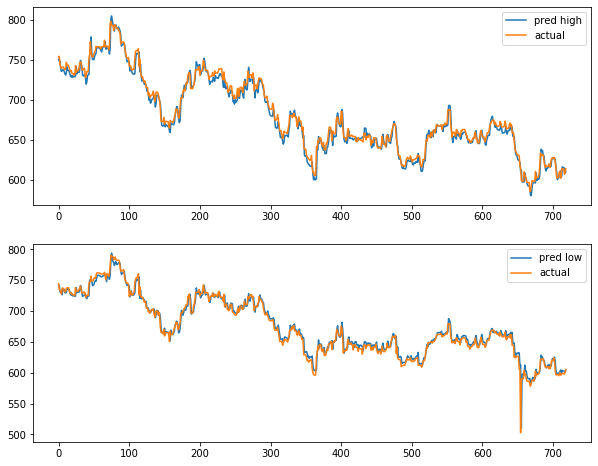

Low MSE: 66.0300362553839
Training loss: 0.00034598822821111475
Val loss high: 0.00015564653656839603
Val loss low: 0.0005006555688412506
Avg val loss 0.0003281510527048233
val loss decreased
Epoch: 1
training...


completed training
High MSE: 44.028047747628925


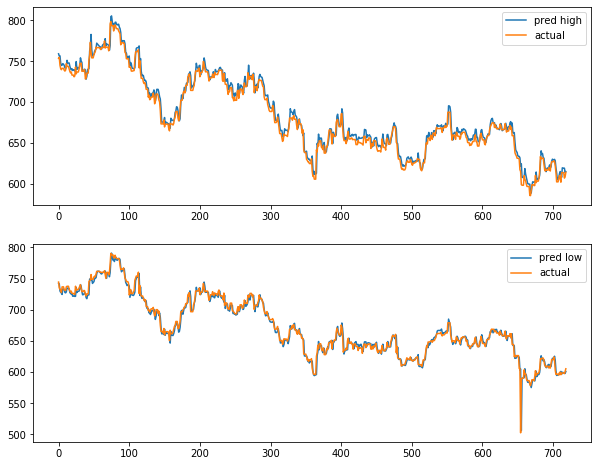

Low MSE: 58.308582719902695
Training loss: 0.00023025626622820213
Val loss high: 0.00014003642673054878
Val loss low: 0.0004729883349684978
Avg val loss 0.0003065123808495233
val loss decreased
Epoch: 2
training...


completed training
High MSE: 32.87565646362911


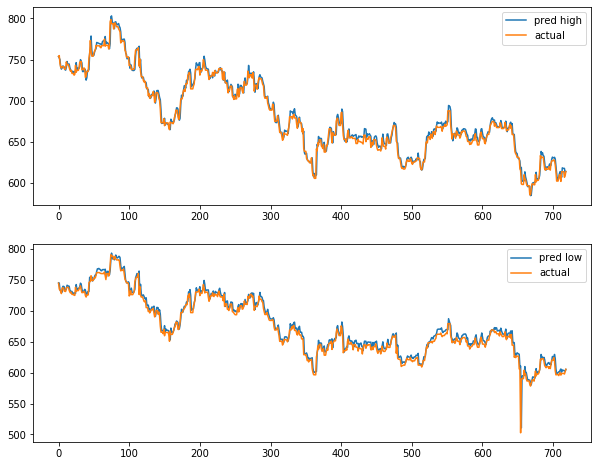

Low MSE: 74.31081880309625
Training loss: 0.00021451555013065845
Val loss high: 0.00013865561282604084
Val loss low: 0.0005161468466091275
Avg val loss 0.0003274012297175842
val loss increased
Epoch: 3
training...


completed training
High MSE: 40.99072465679259


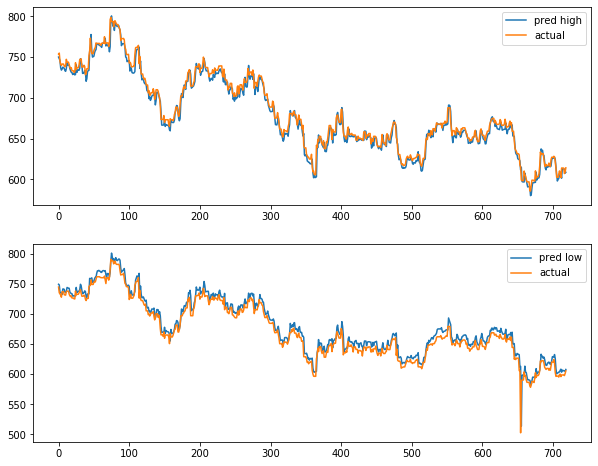

Low MSE: 115.3345979024438
Training loss: 0.0002134062431189854
Val loss high: 0.00012519888105165384
Val loss low: 0.0005992620475848777
Avg val loss 0.00036223046431826575
val loss increased
Epoch: 4
training...


completed training
High MSE: 78.53216371421671


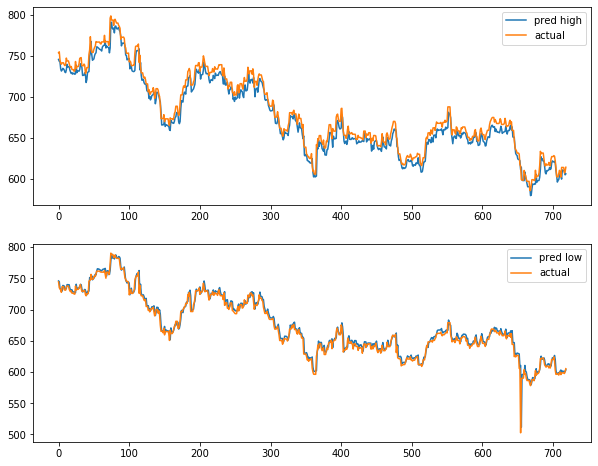

Low MSE: 63.02148924308331
Training loss: 0.00021593177714784203
Val loss high: 0.00019628421284090266
Val loss low: 0.0004706864310041538
Avg val loss 0.00033348532192252825
val loss increased
Epoch: 5
training...


completed training
High MSE: 30.01775792905233


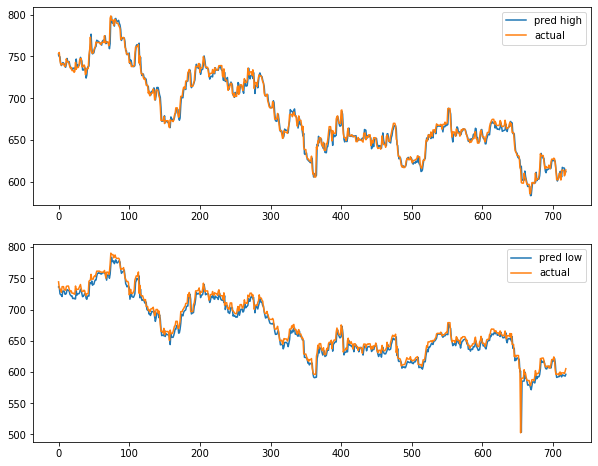

Low MSE: 79.58427434603627
Training loss: 0.0002141346108499152
Val loss high: 0.00011900442322769699
Val loss low: 0.0004898093796288865
Avg val loss 0.0003044069014282917
val loss decreased
Epoch: 6
training...


completed training
High MSE: 59.17798653963066


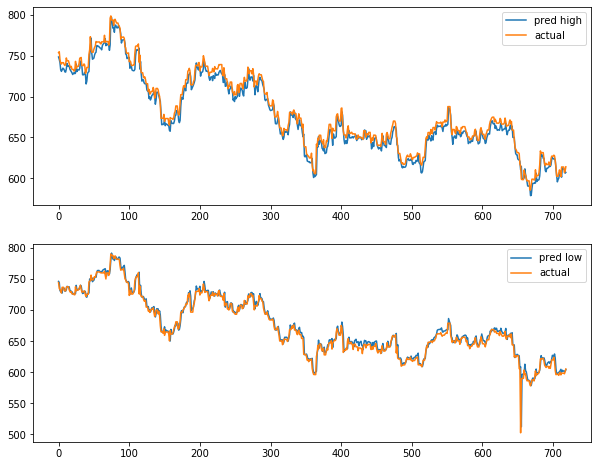

Low MSE: 63.47901467898917
Training loss: 0.00020555928677919107
Val loss high: 0.00015404514402428575
Val loss low: 0.0005161254387034826
Avg val loss 0.0003350852913638842
val loss increased
Epoch: 7
training...


completed training
High MSE: 68.32208524180513


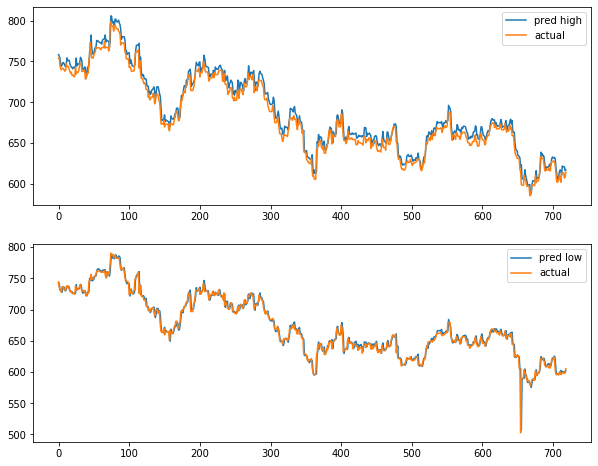

Low MSE: 56.727859420553145
Training loss: 0.00020654486965286675
Val loss high: 0.0001552062774565497
Val loss low: 0.00047065906341837885
Avg val loss 0.00031293267043746426
val loss increased
Epoch: 8
training...


completed training
High MSE: 30.77207214103255


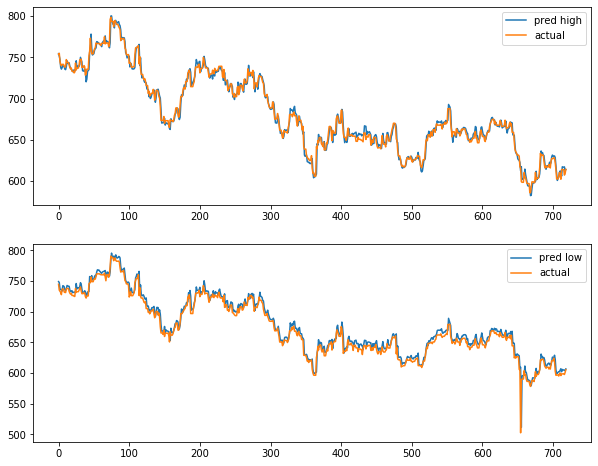

Low MSE: 80.27015398924415
Training loss: 0.00020589949390364048
Val loss high: 0.00014483197404032124
Val loss low: 0.0005111697521805115
Avg val loss 0.00032800086311041637
val loss increased
Epoch: 9
training...


completed training
High MSE: 29.389296289927028


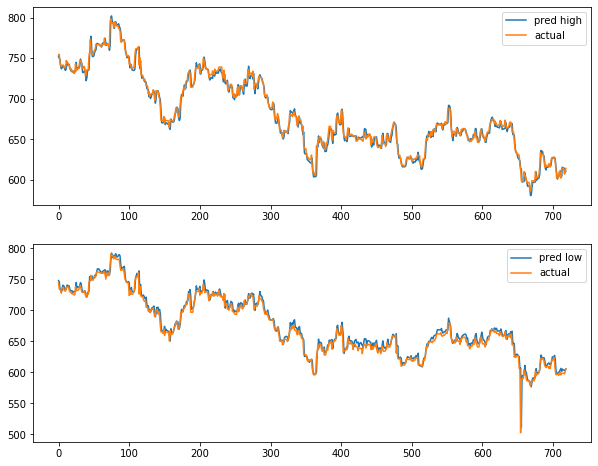

Low MSE: 68.282133721392
Training loss: 0.00020344609507818602
Val loss high: 0.00011317116709788977
Val loss low: 0.0005028670843265676
Avg val loss 0.0003080191257122287
val loss increased


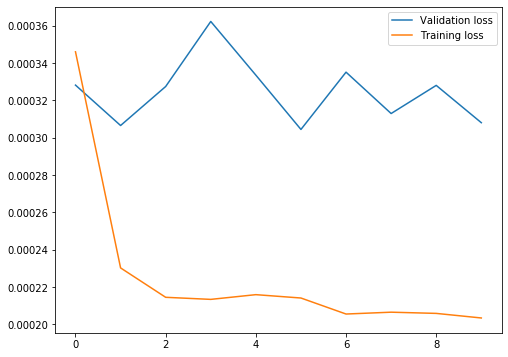

In [197]:
train_env=TrainingEnv(environment)
train_env.train()